<a href="https://colab.research.google.com/github/allythe/Alg_Struct_of_Data_FALT2022/blob/main/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import resources
import os
from PIL import Image  # Import the Image class from the PIL library for image processing
from io import BytesIO  # Import BytesIO for handling input/output streams
import matplotlib.pyplot as plt  # Import pyplot for plotting
import numpy as np  # Import NumPy for numerical computing
import skimage
from skimage.metrics import structural_similarity as ssim
import math

from tqdm import tqdm
import torch  # Import PyTorch
import torch.nn as nn
import torch.optim as optim  # Import the optimization module from PyTorch
import requests  # Import the requests library for making HTTP requests
from torchvision import transforms, models  # Import transforms and models from torchvision for computer vision
from typing import Optional, Tuple  # Import type hints
import logging
from torchvision.models import VGG16_Weights, VGG19_Weights

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/DT088A_MachineLearning/implementation/"

VGG16.ipynb  VGG19.ipynb


## Test data

In [ ]:
content_images = [
    "../images/content/NPRgeneral_benchmark/desert1024.jpg",
    "../images/content/NPRgeneral_benchmark/mac1024.jpg",
    "../images/content/NPRgeneral_benchmark/cat1024.jpg",
    "../images/content/NPRgeneral_benchmark/athletes1024.jpg",
    "../images/content/NPRgeneral_benchmark/tomato1024.jpg",
    "../images/content/NPRgeneral_benchmark/snow1024.jpg",
    "../images/content/NPRgeneral_benchmark/yemeni1024.jpg",
    "../images/content/NPRgeneral_benchmark/daisy1024.jpg",
    "../images/content/NPRgeneral_benchmark/cabbage1024.jpg",
    "../images/content/NPRgeneral_benchmark/city1024.jpg"
]

style_images = [
    "../images/style/TheKiss_Klimt.png",
    "../images/style/StarryNight_VanGogh.png",
    "../images/style/ThreeFishingBoats_Monet.png",
    "../images/style/RitmoPlastico_Severini.png",
    "../images/style/TheGreatWaveOffKanagawa_Hokusai.png",
    "../images/style/ThePersistenceOfMemory_Dali.png",
    "../images/style/PencilCity.png",
    "../images/style/PenLion.png",
    "../images/style/Hohloma.png",
    "../images/style/IndianOrnament.png"
]

In [ ]:
# content_dir = "../images/content/NPRgeneral_benchmark"
# style_dir   = "../images/style"

content_dir = "/content/drive/MyDrive/DT088A_MachineLearning/images/content/NPRgeneral_benchmark"
style_dir   = "/content/drive/MyDrive/DT088A_MachineLearning/images/style"

def get_first_n_images(folder, n=10):
   images = []
   for entry in os.scandir(folder):
       if entry.is_file() and entry.name.lower().endswith((".png", ".jpg", ".jpeg")):
           images.append(entry.path)

   return images[-10:]

content_images = get_first_n_images(content_dir)
style_images   = get_first_n_images(style_dir)

pairs = list(zip(content_images, style_images))

print("Generated 10 pairs:")
for i, (c, s) in enumerate(pairs):
    print(f"{i+1}. CONTENT = {c}   |   STYLE = {s}")

Generated 10 pairs:
1. CONTENT = /content/drive/MyDrive/DT088A_MachineLearning/images/content/NPRgeneral_benchmark/desert1024.jpg   |   STYLE = /content/drive/MyDrive/DT088A_MachineLearning/images/style/TheKiss_Klimt.png
2. CONTENT = /content/drive/MyDrive/DT088A_MachineLearning/images/content/NPRgeneral_benchmark/mac1024.jpg   |   STYLE = /content/drive/MyDrive/DT088A_MachineLearning/images/style/StarryNight_VanGogh.png
3. CONTENT = /content/drive/MyDrive/DT088A_MachineLearning/images/content/NPRgeneral_benchmark/cat1024.jpg   |   STYLE = /content/drive/MyDrive/DT088A_MachineLearning/images/style/ThreeFishingBoats_Monet.png
4. CONTENT = /content/drive/MyDrive/DT088A_MachineLearning/images/content/NPRgeneral_benchmark/athletes1024.jpg   |   STYLE = /content/drive/MyDrive/DT088A_MachineLearning/images/style/RitmoPlastico_Severini.png
5. CONTENT = /content/drive/MyDrive/DT088A_MachineLearning/images/content/NPRgeneral_benchmark/tomato1024.jpg   |   STYLE = /content/drive/MyDrive/DT088A_M

In [ ]:
vgg19_model = models.vgg19(weights=VGG19_Weights.DEFAULT).features
vgg16_model = models.vgg16(weights=VGG16_Weights.DEFAULT).features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 197MB/s]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 171MB/s]


In [ ]:
vgg16_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
vgg19_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## NST implementation

In [ ]:
class NeuralStyleTransfer:
    def __init__(self, vgg_type, lr = 0.003):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.logger = self._init_logger()
        self.vgg_type = vgg_type
        self.vgg = self._init_vgg()
        self.vgg.to(self.device)
        self.lr = lr

        self.logger.info(f"VGG model {self.vgg_type} initialized")

    def _init_vgg(self):
        if self.vgg_type == "vgg16":
            vgg = models.vgg16(weights=VGG16_Weights.DEFAULT).features
        elif self.vgg_type == "vgg19":
            vgg = models.vgg19(weights=VGG19_Weights.DEFAULT).features
        else:
          raise ValueError(f"Unknown VGG type: {self.vgg_type}")

        for param in vgg.parameters():
            param.requires_grad_(False)

        return vgg

    def _init_logger(self):
        logger = logging.getLogger(__name__)
        logging.basicConfig(format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                      datefmt='%H:%M:%S',
                      level=logging.INFO,
                      force=True )
        logger.info("Logger created")
        return logger

    def print_vgg_layers(self):
        print(self.vgg)

    def _check_image(self, img_tensor, name="image"):
        self.logger.info(f"Checking {name}...")

        if not isinstance(img_tensor, torch.Tensor):
            raise TypeError(f"{name} is not a tensor")


        # Check expected shape (1, 3, 256, 256)
        if img_tensor.shape[1:] != (3, 256, 256):
            self.logger.warning(f"{name} has unexpected shape: {img_tensor.shape}")
        else:
            self.logger.info(f"{name} shape is correct.")

    def _compute_gram_matrix(self, input):
        b, d, h, w = input.size()
        features = input.view(b * d, h * w)
        gram = torch.mm(features, features.t())
        return gram

    def _extract_features(self, image, layers = None) -> dict:

        if layers is None and self.vgg_type == "vgg16":
            layers = {'0': 'conv1_1',
                      '5': 'conv2_1',
                      '10': 'conv3_1',
                      '17': 'conv4_1',
                      '19': 'conv4_2',
                      '24': 'conv5_1'}
        elif layers is None and self.vgg_type == "vgg19":
            layers = {'0': 'conv1_1', # style
                    '5': 'conv2_1',   # style
                    '10': 'conv3_1',  # style
                    '19': 'conv4_1',  # style
                    '21': 'conv4_2',  # content
                    '28': 'conv5_1'}  # style
        else:
            raise ValueError(f"For {self.vgg_type} the layers are undefined")

        features = {}
        x = image
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x  # Store the features for specified layers
        return features

    def _im_convert(self, tensor):
        image = tensor.cpu().clone().detach().squeeze(0)  # remove batch dimension
        image = image.numpy().transpose(1, 2, 0)  # C x H x W -> H x W x C
        # Denormalize
        image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        image = image.clip(0, 1)
        return image


    def _load_img(self, img_path):
        img = skimage.io.imread(img_path)
        img = Image.fromarray(img)

        in_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

        img = in_transform(img)[:3, :, :].unsqueeze(0).to(self.device)
        return img


    def __call__(self, context_img_path, style_img_path, epochs = 2000, content_weight = 100, style_weight=1, show_every = 100):
        content_img = self._load_img(context_img_path)
        style_img = self._load_img(style_img_path)

        self._check_image(content_img, "content image")
        self._check_image(style_img, "style image")

        content_features = self._extract_features(content_img)
        style_features = self._extract_features(style_img)
        style_grams = {layer: self._compute_gram_matrix(style_features[layer]) for layer in style_features}

        # target = content_img.clone().requires_grad_(True).to(self.device)

        target = content_img.clone() * 0.3 + torch.randn_like(content_img) * 0.5

        target.requires_grad_(True)
        target.to(self.device)

        optimizer = optim.Adam([target], lr=self.lr)\

        # layer_weights = {'conv1_1': 1.0, 'conv2_1': 0.75, 'conv3_1': 0.2,
        #                  'conv4_1': 0.2, 'conv5_1': 0.2} # style layers

        total_losses = []
        content_losses = []
        style_losses = []

        tqdm_bar = tqdm(range(1, epochs + 1), desc="NST Progress", ncols=200)
        for ii in tqdm_bar:
            target_features = self._extract_features(target)

            # Content loss
            content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2) # content layers

            # Style loss
            style_loss = 0
            for layer in layer_weights:
                target_feature = target_features[layer]
                target_gram = self._compute_gram_matrix(target_feature)
                _, d, h, w = target_feature.shape
                style_gram = style_grams[layer]
                layer_loss = layer_weights[layer] * torch.mean((target_gram - style_gram)**2)
                style_loss += layer_loss / (d * h * w)

            # Total loss
            # if ii % 2 == 0:
            #     total_loss = content_weight * content_loss + style_weight * style_loss
            # else:
            #     total_loss = content_weight * content_loss + style_weight * style_loss

            total_loss = content_weight * content_loss + style_weight * style_loss

            content_losses.append(content_loss.item())
            style_losses.append(style_loss.item())
            total_losses.append(total_loss.item())

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            tqdm_bar.set_postfix({
                  "Epoch": f"{ii}",
                  "Total": f"{total_loss.item():.2f}",
                  "Content": f"{(content_loss.item()*content_weight):.2f}",
                  "Style": f"{(style_loss.item()*style_weight):.2f}"
              })

            # Plot intermediate result every show_every steps
            if ii % show_every == 0:
                plt.figure(figsize=(15,5))

                # Content
                plt.subplot(1, 3, 1)
                plt.imshow(self._im_convert(content_img))
                plt.title("Content")
                plt.axis('off')

                # Style
                plt.subplot(1, 3, 2)
                plt.imshow(self._im_convert(style_img))
                plt.title("Style")
                plt.axis('off')

                # Current Target
                plt.subplot(1, 3, 3)
                plt.imshow(self._im_convert(target))
                plt.title(f"Target Step {ii}")
                plt.axis('off')

                plt.show()

        # # Plot the losses
        # plt.figure(figsize=(10,5))
        # plt.subplot(1, 2, 1)

        # plt.plot(total_losses, label="Total Loss")
        # plt.plot(content_losses, label="Content Loss")
        # plt.plot(style_losses, label="Style Loss")
        # plt.xlabel("Iteration")
        # plt.ylabel("Loss")
        # plt.title("NST Losses over Iterations")
        # plt.legend()

        #  # Current Target
        # plt.subplot(1, 2, 2)
        # plt.imshow(self._im_convert(target))
        # plt.title(f"Target Step {ii}")
        # plt.axis('off')

        # plt.show()

        # plt.show()

        return (
                self._im_convert(target),
                {
                    "content_loss": content_losses[-1],
                    "style_loss": style_losses[-1],
                    "total_loss": total_losses[-1]
                }
               )

## Change style_weight and content_weight

In [ ]:
nst = NeuralStyleTransfer(vgg_type="vgg19")

weight_configs = [
    # content/style
    (1, 1),
    (100, 1),
    (10000, 1),
    (1000000, 1),
    (1, 100),
    (1, 10000),
    (1, 1000000)
]

output_dir = "/content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/"
os.makedirs(output_dir, exist_ok=True)

for pair_index, (content_img_path, style_img_path) in enumerate(pairs):

    print(f"\n====================")
    print(f"PAIR {pair_index+1}/{len(pairs)}")
    print(f"Content: {content_img_path}")
    print(f"Style:   {style_img_path}")
    print(f"====================\n")

    pair_dir = os.path.join(output_dir, f"pair_{pair_index+1}")
    os.makedirs(pair_dir, exist_ok=True)

    pair_results = []

    for cw, sw in weight_configs:
        fname = f"cw{cw}_sw{sw}.png"
        save_path = os.path.join(pair_dir, fname)

        if os.path.exists(save_path):
            print(f"Skipping existing file: {save_path}")
            # load existing image for grid
            img = skimage.io.imread(save_path)
            pair_results.append((cw, sw, img))
            continue

        print(f"--- Running NST: content={cw}, style={sw} ---")
        result_img = nst(
            context_img_path=content_img_path,
            style_img_path=style_img_path,
            epochs=1500,
            content_weight=cw,
            style_weight=sw,
            show_every=999999
        )

        plt.imsave(save_path, result_img)
        print(f"Saved: {save_path}")
        pair_results.append((cw, sw, result_img))

    # ====== Create grid ======
    fig = plt.figure(figsize=(12, 12))

    # 1st row: content, style, first result
    ax = fig.add_subplot(3, 3, 1)
    ax.imshow(skimage.io.imread(content_img_path))
    ax.set_title("Content")
    ax.axis("off")

    ax = fig.add_subplot(3, 3, 2)
    ax.imshow(skimage.io.imread(style_img_path))
    ax.set_title("Style")
    ax.axis("off")

    cw, sw, img = pair_results[0]
    ax = fig.add_subplot(3, 3, 3)
    ax.imshow(img)
    ax.set_title(f"cw={cw}, sw={sw}")
    ax.axis("off")

    # 2nd row: results 2,3,4
    for i, idx in enumerate([1, 2, 3]):
        cw, sw, img = pair_results[idx]
        ax = fig.add_subplot(3, 3, 4+i)
        ax.imshow(img)
        ax.set_title(f"cw={cw}, sw={sw}")
        ax.axis("off")

    # 3rd row: results 5,6,7
    for i, idx in enumerate([4, 5, 6]):
        cw, sw, img = pair_results[idx]
        ax = fig.add_subplot(3, 3, 7+i)
        ax.imshow(img)
        ax.set_title(f"cw={cw}, sw={sw}")
        ax.axis("off")

    plt.tight_layout()
    grid_path = os.path.join(pair_dir, "grid.png")
    plt.savefig(grid_path, dpi=200)
    plt.close()
    print(f"Saved GRID: {grid_path}")

print("\n🎉 ALL DONE! Grids saved to:", output_dir)

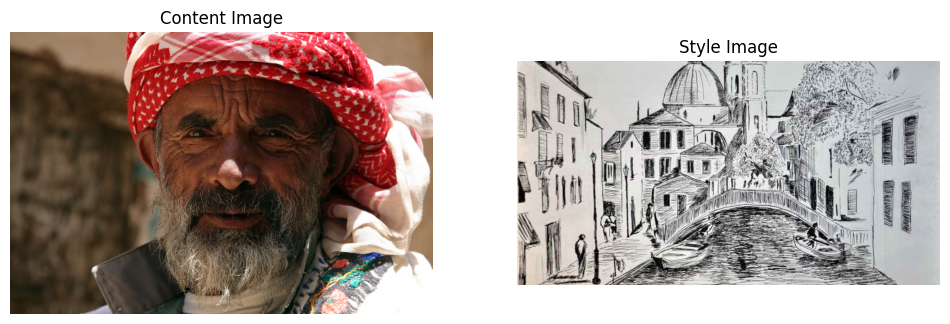

In [ ]:
content_img = skimage.io.imread(content_img_path)
style_img = skimage.io.imread(style_img_path)

num_results = len(results)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(content_img)
plt.title("Content Image")
plt.axis("off")

plt.subplot(122)
plt.imshow(style_img)
plt.title("Style Image")
plt.axis("off")
None

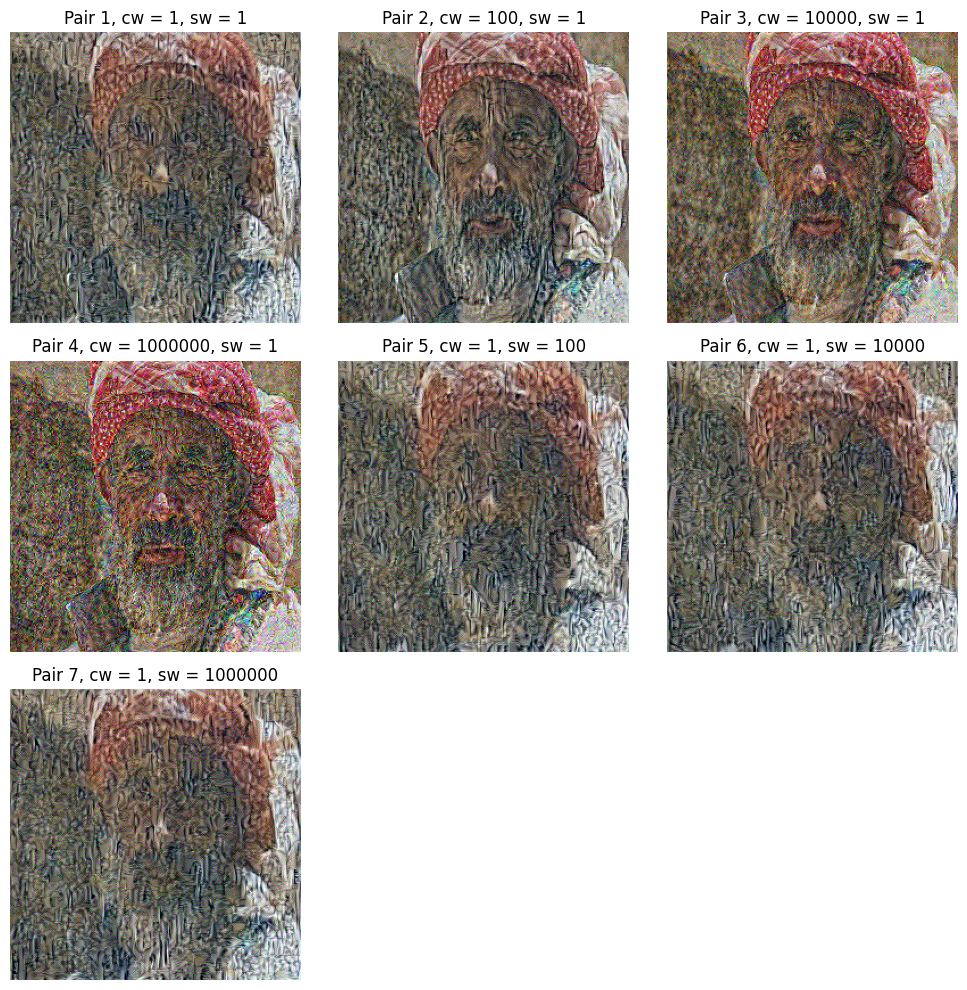

In [ ]:
plt.figure(figsize=(10, 10))

for i, (cw, sw, img) in enumerate(results):
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f"Pair {i+1}, cw = {cw}, sw = {sw}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Change style layers

In [ ]:
class NeuralStyleTransferStyleLayers:
    def __init__(self, vgg_type, content_layers, style_layers, lr = 0.003):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.logger = self._init_logger()
        self.vgg_type = vgg_type
        self.vgg = self._init_vgg()
        self.vgg.to(self.device)
        self.lr = lr
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.style_layer_weights = {'conv1_1': 1.0, 'conv2_1': 0.75, 'conv3_1': 0.2,
                         'conv4_1': 0.2, 'conv5_1': 0.2}
        self.content_layer_weights = {'conv1_2': 1.0, 'conv2_2': 1, 'conv3_2': 1,
                         'conv4_2': 1, 'conv5_2': 1}

        self.logger.info(f"VGG model {self.vgg_type} initialized")

    def _init_vgg(self):
        if self.vgg_type == "vgg16":
            vgg = models.vgg16(weights=VGG16_Weights.DEFAULT).features
        elif self.vgg_type == "vgg19":
            vgg = models.vgg19(weights=VGG19_Weights.DEFAULT).features
        else:
          raise ValueError(f"Unknown VGG type: {self.vgg_type}")

        for param in vgg.parameters():
            param.requires_grad_(False)

        return vgg

    def _init_logger(self):
        logger = logging.getLogger(__name__)
        logging.basicConfig(format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                      datefmt='%H:%M:%S',
                      level=logging.INFO,
                      force=True )
        logger.info("Logger created")
        return logger

    def print_vgg_layers(self):
        print(self.vgg)

    def _check_image(self, img_tensor, name="image"):
        self.logger.info(f"Checking {name}...")

        if not isinstance(img_tensor, torch.Tensor):
            raise TypeError(f"{name} is not a tensor")


        # Check expected shape (1, 3, 256, 256)
        if img_tensor.shape[1:] != (3, 256, 256):
            self.logger.warning(f"{name} has unexpected shape: {img_tensor.shape}")
        else:
            self.logger.info(f"{name} shape is correct.")

    def _compute_gram_matrix(self, input):
        b, d, h, w = input.size()
        features = input.view(b * d, h * w)
        gram = torch.mm(features, features.t())
        return gram

    def _extract_features(self, image) -> dict:
        needed_layers = set(self.content_layers.values()) | set(self.style_layers.values())

        if self.vgg_type == "vgg16":
            layer_map = {
                '0': 'conv1_1', '1': 'relu1_1',
                '2': 'conv1_2', '3': 'relu1_2',
                '5': 'conv2_1', '6': 'relu2_1',
                '7': 'conv2_2', '8': 'relu2_2',
                '10': 'conv3_1', '11': 'relu3_1',
                '12': 'conv3_2', '13': 'relu3_2',
                '14': 'conv3_3', '15': 'relu3_3',
                '17': 'conv4_1', '18': 'relu4_1',
                '19': 'conv4_2', '20': 'relu4_2',
                '21': 'conv4_3', '22': 'relu4_3',
                '24': 'conv5_1', '25': 'relu5_1',
                '26': 'conv5_2', '27': 'relu5_2',
                '28': 'conv5_3', '29': 'relu5_3',
            }

        elif self.vgg_type == "vgg19":
            layer_map = {
                '0': 'conv1_1', '1': 'relu1_1',
                '2': 'conv1_2', '3': 'relu1_2',
                '5': 'conv2_1', '6': 'relu2_1',
                '7': 'conv2_2', '8': 'relu2_2',
                '10': 'conv3_1', '11': 'relu3_1',
                '12': 'conv3_2', '13': 'relu3_2',
                '14': 'conv3_3', '15': 'relu3_3',
                '16': 'conv3_4', '17': 'relu3_4',
                '19': 'conv4_1', '20': 'relu4_1',
                '21': 'conv4_2', '22': 'relu4_2',
                '23': 'conv4_3', '24': 'relu4_3',
                '25': 'conv4_4', '26': 'relu4_4',
                '28': 'conv5_1', '29': 'relu5_1',
                '30': 'conv5_2', '31': 'relu5_2',
                '32': 'conv5_3', '33': 'relu5_3',
                '34': 'conv5_4', '35': 'relu5_4',
            }

        features = {}
        x = image

        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in layer_map:
                lname = layer_map[name]
                if lname in needed_layers:
                    features[lname] = x

        return features

    def _im_convert(self, tensor):
        image = tensor.cpu().clone().detach().squeeze(0)  # remove batch dimension
        image = image.numpy().transpose(1, 2, 0)  # C x H x W -> H x W x C
        # Denormalize
        image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        image = image.clip(0, 1)
        return image


    def _load_img(self, img_path):
        img = skimage.io.imread(img_path)
        img = Image.fromarray(img)

        in_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

        img = in_transform(img)[:3, :, :].unsqueeze(0).to(self.device)
        return img


    def __call__(self, context_img_path, style_img_path, epochs = 2000, content_weight = 100, style_weight=1, show_every = 100):
        content_img = self._load_img(context_img_path)
        style_img = self._load_img(style_img_path)

        self._check_image(content_img, "content image")
        self._check_image(style_img, "style image")

        content_features = self._extract_features(content_img)
        style_features = self._extract_features(style_img)
        style_grams = {layer: self._compute_gram_matrix(style_features[layer]) for layer in  self.style_layers.values()}

        target = content_img.clone() * 0.3 + torch.randn_like(content_img) * 0.5

        target = target.to(self.device)
        target.requires_grad_(True)

        optimizer = optim.Adam([target], lr=self.lr)

        total_losses = []
        content_losses = []
        style_losses = []


        tqdm_bar = tqdm(range(1, epochs + 1), desc="NST Progress", ncols=200)
        for ii in tqdm_bar:
            target_features = self._extract_features(target)

            # content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
            content_loss = 0

            for layer in self.content_layers.values():

                target_feature = target_features[layer]
                content_feature = content_features[layer]

                w = self.content_layer_weights[layer]

                content_loss += w * torch.mean((target_feature - content_feature)**2)

            # Style loss
            style_loss = 0

            for layer in self.style_layers.values():

                target_feature = target_features[layer]
                target_gram = self._compute_gram_matrix(target_feature)
                _, d, h, w = target_feature.shape
                style_gram = style_grams[layer]
                layer_loss = self.style_layer_weights[layer] * torch.mean((target_gram - style_gram)**2)
                style_loss += layer_loss / (d * h * w)


            total_loss = content_weight * content_loss + style_weight * style_loss

            content_losses.append(content_loss.item())
            style_losses.append(style_loss.item())
            total_losses.append(total_loss.item())

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            tqdm_bar.set_postfix({
                  "Epoch": f"{ii}",
                  "Total": f"{total_loss.item():.2f}",
                  "Content": f"{(content_loss.item()*content_weight):.2f}",
                  "Style": f"{(style_loss.item()*style_weight):.2f}"
              })

            # Plot intermediate result every show_every steps
            if ii % show_every == 0:
                plt.figure(figsize=(15,5))

                # Content
                plt.subplot(1, 3, 1)
                plt.imshow(self._im_convert(content_img))
                plt.title("Content")
                plt.axis('off')

                # Style
                plt.subplot(1, 3, 2)
                plt.imshow(self._im_convert(style_img))
                plt.title("Style")
                plt.axis('off')

                # Current Target
                plt.subplot(1, 3, 3)
                plt.imshow(self._im_convert(target))
                plt.title(f"Target Step {ii}")
                plt.axis('off')

                plt.show()



        return (
                self._im_convert(target),
                {
                    "content_loss": content_losses[-1],
                    "style_loss": style_losses[-1],
                    "total_loss": total_losses[-1]
                }
               )

In [ ]:
style_layers_list = [
    {'0': 'conv1_1'},
    {'0': 'conv1_1', '5': 'conv2_1' },
    {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1'},
    {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1'},
    {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '28': 'conv5_1'}
]

content_layers_list = [
    {'2': 'conv1_2'},
    {'2': 'conv1_2', '7': 'conv2_2'},
    {'2': 'conv1_2', '7': 'conv2_2', '12': 'conv3_2'},
    {'2': 'conv1_2', '7': 'conv2_2', '12': 'conv3_2', '21': 'conv4_2'},
]

output_dir = "../results_vgg19/style_layers/"
os.makedirs(output_dir, exist_ok=True)

for pair_index, (content_img_path, style_img_path) in enumerate(pairs):

    print(f"\n=== Processing PAIR {pair_index+1}/{len(pairs)} ===")
    print(content_img_path)
    print(style_img_path)

    pair_dir = os.path.join(output_dir, f"pair_{pair_index+1}")
    os.makedirs(pair_dir, exist_ok=True)

    results = []  # store (img, loss_dict, content_layer_index, style_layer_index)

    for c_l_index, content_layers in enumerate(content_layers_list):
        for s_l_index, style_layers in enumerate(style_layers_list):

            print(f"\nRunning NST with content_layers {c_l_index+1}/{len(content_layers_list)}, "
                  f"style_layers {s_l_index+1}/{len(style_layers_list)}")
            print("Content layers:", content_layers)
            print("Style layers:", style_layers)

            save_path = os.path.join(pair_dir, f"layers_C{c_l_index+1}_S{s_l_index+1}.png")

            nst = NeuralStyleTransferStyleLayers(
                vgg_type="vgg19",
                content_layers=content_layers,
                style_layers=style_layers
            )

            if os.path.exists(save_path):
                print(f"Loading existing file: {save_path}")
                img = skimage.io.imread(save_path)
                loss_dict = None
            else:
                img, loss_dict = nst(
                    context_img_path=content_img_path,
                    style_img_path=style_img_path,
                    epochs=1500,
                    content_weight=1,
                    style_weight=1,
                    show_every=999999
                )
                if img is not None:
                    plt.imsave(save_path, img)
                    print(f"Saved: {save_path}")

            results.append((img, loss_dict, c_l_index+1, s_l_index+1))

    # Plot grid
    n_results = len(results)
    cols = 5
    rows = math.ceil((n_results + 2) / cols)  # +2 for content & style images
    fig = plt.figure(figsize=(4*cols, 4*rows))

    # Content image
    ax = fig.add_subplot(rows, cols, 1)
    ax.imshow(skimage.io.imread(content_img_path))
    ax.set_title("Content")
    ax.axis("off")

    # Style image
    ax = fig.add_subplot(rows, cols, 2)
    ax.imshow(skimage.io.imread(style_img_path))
    ax.set_title("Style")
    ax.axis("off")

    # NST results
    for idx, (img, loss_dict, c_idx, s_idx) in enumerate(results):
        ax = fig.add_subplot(rows, cols, 3 + idx)
        ax.imshow(img)
        if loss_dict is None:
            title = f"C{c_idx} S{s_idx}"
        else:
            title = f"C{c_idx} S{s_idx}\nC:{loss_dict['content_loss']:.2f}  S:{loss_dict['style_loss']:.2f}"
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    grid_path = os.path.join(pair_dir, "grid.png")
    plt.savefig(grid_path, dpi=200)
    plt.close()
    print(f"Saved GRID for pair {pair_index+1}: {grid_path}")

01:22:57,723 __main__ INFO Logger created



=== Processing PAIR 1/10 ===
../images/content/NPRgeneral_benchmark/yemeni1024.jpg
../images/style/WhiteZigZags_Kandinsky.png

Running NST with content_layers 1/4, style_layers 1/5
Content layers: {'2': 'conv1_2'}
Style layers: {'0': 'conv1_1'}


01:23:01,184 __main__ INFO VGG model vgg19 initialized
01:23:01,317 __main__ INFO Checking content image...
01:23:01,318 __main__ INFO content image shape is correct.
01:23:01,318 __main__ INFO Checking style image...
01:23:01,318 __main__ INFO style image shape is correct.
NST Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:13<00:00, 111.85it/s, Epoch=1500, Total=1.56, Content=0.97, Style=0.59]
01:23:15,810 __main__ INFO Logger created


Saved: ../results_vgg19/style_layers/pair_1/layers_C1_S1.png

Running NST with content_layers 1/4, style_layers 2/5
Content layers: {'2': 'conv1_2'}
Style layers: {'0': 'conv1_1', '5': 'conv2_1'}


01:23:17,640 __main__ INFO VGG model vgg19 initialized
01:23:17,669 __main__ INFO Checking content image...
01:23:17,670 __main__ INFO content image shape is correct.
01:23:17,671 __main__ INFO Checking style image...
01:23:17,671 __main__ INFO style image shape is correct.
NST Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:15<00:00, 99.75it/s, Epoch=1500, Total=8.07, Content=2.09, Style=5.98]
01:23:32,737 __main__ INFO Logger created


Saved: ../results_vgg19/style_layers/pair_1/layers_C1_S2.png

Running NST with content_layers 1/4, style_layers 3/5
Content layers: {'2': 'conv1_2'}
Style layers: {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1'}


01:23:34,464 __main__ INFO VGG model vgg19 initialized
01:23:34,493 __main__ INFO Checking content image...
01:23:34,494 __main__ INFO content image shape is correct.
01:23:34,494 __main__ INFO Checking style image...
01:23:34,495 __main__ INFO style image shape is correct.
NST Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:16<00:00, 88.57it/s, Epoch=1500, Total=11.21, Content=2.12, Style=9.09]
01:23:51,460 __main__ INFO Logger created


Saved: ../results_vgg19/style_layers/pair_1/layers_C1_S3.png

Running NST with content_layers 1/4, style_layers 4/5
Content layers: {'2': 'conv1_2'}
Style layers: {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1'}


01:23:53,85 __main__ INFO VGG model vgg19 initialized
01:23:53,113 __main__ INFO Checking content image...
01:23:53,113 __main__ INFO content image shape is correct.
01:23:53,114 __main__ INFO Checking style image...
01:23:53,114 __main__ INFO style image shape is correct.
NST Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:19<00:00, 77.96it/s, Epoch=1500, Total=12.81, Content=2.13, Style=10.68]
01:24:12,389 __main__ INFO Logger created


Saved: ../results_vgg19/style_layers/pair_1/layers_C1_S4.png

Running NST with content_layers 1/4, style_layers 5/5
Content layers: {'2': 'conv1_2'}
Style layers: {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '28': 'conv5_1'}


01:24:14,62 __main__ INFO VGG model vgg19 initialized
01:24:14,91 __main__ INFO Checking content image...
01:24:14,91 __main__ INFO content image shape is correct.
01:24:14,92 __main__ INFO Checking style image...
01:24:14,92 __main__ INFO style image shape is correct.
NST Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:21<00:00, 68.94it/s, Epoch=1500, Total=12.74, Content=2.10, Style=10.64]
01:24:35,880 __main__ INFO Logger created


Saved: ../results_vgg19/style_layers/pair_1/layers_C1_S5.png

Running NST with content_layers 2/4, style_layers 1/5
Content layers: {'2': 'conv1_2', '7': 'conv2_2'}
Style layers: {'0': 'conv1_1'}


01:24:37,469 __main__ INFO VGG model vgg19 initialized
01:24:37,497 __main__ INFO Checking content image...
01:24:37,498 __main__ INFO content image shape is correct.
01:24:37,499 __main__ INFO Checking style image...
01:24:37,499 __main__ INFO style image shape is correct.
NST Progress:  28%|██████████████████████████▊                                                                      | 414/1500 [00:04<00:11, 97.42it/s, Epoch=414, Total=8.59, Content=4.67, Style=3.92]


KeyboardInterrupt: 

# Pooling experiments

In [ ]:
class NeuralStyleTransferPooling:
    def __init__(self, vgg_type, content_layers, style_layers, pooling = "max", lr = 0.003):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.pooling = pooling

        self.logger = self._init_logger()
        self.vgg_type = vgg_type
        self.vgg = self._init_vgg()
        self.vgg.to(self.device)
        self.lr = lr
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.style_layer_weights = {'conv1_1': 1.0, 'conv2_1': 0.75, 'conv3_1': 0.2,
                         'conv4_1': 0.2, 'conv5_1': 0.2}
        self.content_layer_weights = {'conv1_2': 1.0, 'conv2_2': 1, 'conv3_2': 1,
                         'conv4_2': 1, 'conv5_2': 1}

        self.logger.info(f"VGG model {self.vgg_type} initialized")

    def _init_vgg(self):
        if self.vgg_type == "vgg16":
            vgg = models.vgg16(weights=VGG16_Weights.DEFAULT).features
        elif self.vgg_type == "vgg19":
            vgg = models.vgg19(weights=VGG19_Weights.DEFAULT).features
        else:
          raise ValueError(f"Unknown VGG type: {self.vgg_type}")

        if self.pooling == "avg":
            for i, layer in enumerate(vgg):
                if isinstance(layer, torch.nn.MaxPool2d):
                    vgg[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
            self.logger.info("Replaced MaxPool with AvgPool")



        for param in vgg.parameters():
            param.requires_grad_(False)


        return vgg

    def _init_logger(self):
        logger = logging.getLogger(__name__)
        logging.basicConfig(format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                      datefmt='%H:%M:%S',
                      level=logging.INFO,
                      force=True )
        logger.info("Logger created")
        return logger

    def print_vgg_layers(self):
        print(self.vgg)

    def _check_image(self, img_tensor, name="image"):
        self.logger.info(f"Checking {name}...")

        if not isinstance(img_tensor, torch.Tensor):
            raise TypeError(f"{name} is not a tensor")


        # Check expected shape (1, 3, 256, 256)
        if img_tensor.shape[1:] != (3, 256, 256):
            self.logger.warning(f"{name} has unexpected shape: {img_tensor.shape}")
        else:
            self.logger.info(f"{name} shape is correct.")

    def _compute_gram_matrix(self, input):
        b, d, h, w = input.size()
        features = input.view(b * d, h * w)
        gram = torch.mm(features, features.t())
        return gram
        # Convert PyTorch tensors (1, 3, H, W) → NumPy (H, W, 3)
    def tensor_to_numpy(self, tensor):
        img = tensor.detach().cpu().clone()
        img = img.squeeze(0).permute(1, 2, 0).numpy()
        img = img.clip(0, 1)
        return img

    def _extract_features(self, image) -> dict:
        needed_layers = set(self.content_layers.values()) | set(self.style_layers.values())

        if self.vgg_type == "vgg16":
            layer_map = {
                '0': 'conv1_1', '1': 'relu1_1',
                '2': 'conv1_2', '3': 'relu1_2',
                '5': 'conv2_1', '6': 'relu2_1',
                '7': 'conv2_2', '8': 'relu2_2',
                '10': 'conv3_1', '11': 'relu3_1',
                '12': 'conv3_2', '13': 'relu3_2',
                '14': 'conv3_3', '15': 'relu3_3',
                '17': 'conv4_1', '18': 'relu4_1',
                '19': 'conv4_2', '20': 'relu4_2',
                '21': 'conv4_3', '22': 'relu4_3',
                '24': 'conv5_1', '25': 'relu5_1',
                '26': 'conv5_2', '27': 'relu5_2',
                '28': 'conv5_3', '29': 'relu5_3',
            }

        elif self.vgg_type == "vgg19":
            layer_map = {
                '0': 'conv1_1', '1': 'relu1_1',
                '2': 'conv1_2', '3': 'relu1_2',
                '5': 'conv2_1', '6': 'relu2_1',
                '7': 'conv2_2', '8': 'relu2_2',
                '10': 'conv3_1', '11': 'relu3_1',
                '12': 'conv3_2', '13': 'relu3_2',
                '14': 'conv3_3', '15': 'relu3_3',
                '16': 'conv3_4', '17': 'relu3_4',
                '19': 'conv4_1', '20': 'relu4_1',
                '21': 'conv4_2', '22': 'relu4_2',
                '23': 'conv4_3', '24': 'relu4_3',
                '25': 'conv4_4', '26': 'relu4_4',
                '28': 'conv5_1', '29': 'relu5_1',
                '30': 'conv5_2', '31': 'relu5_2',
                '32': 'conv5_3', '33': 'relu5_3',
                '34': 'conv5_4', '35': 'relu5_4',
            }

        features = {}
        x = image

        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in layer_map:
                lname = layer_map[name]
                if lname in needed_layers:
                    features[lname] = x

        return features

    def _im_convert(self, tensor):
        image = tensor.cpu().clone().detach().squeeze(0)  # remove batch dimension
        image = image.numpy().transpose(1, 2, 0)  # C x H x W -> H x W x C
        # Denormalize
        image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        image = image.clip(0, 1)
        return image


    def _load_img(self, img_path):
        img = skimage.io.imread(img_path)
        img = Image.fromarray(img)

        in_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

        img = in_transform(img)[:3, :, :].unsqueeze(0).to(self.device)
        return img


    def __call__(self, context_img_path, style_img_path, epochs = 2000, content_weight = 100, style_weight=1, show_every = 100):
        content_img = self._load_img(context_img_path)
        style_img = self._load_img(style_img_path)

        self._check_image(content_img, "content image")
        self._check_image(style_img, "style image")

        content_features = self._extract_features(content_img)
        style_features = self._extract_features(style_img)
        style_grams = {layer: self._compute_gram_matrix(style_features[layer]) for layer in  self.style_layers.values()}

        target = content_img.clone() * 0.3 + torch.randn_like(content_img) * 0.5

        target = target.to(self.device)
        target.requires_grad_(True)

        optimizer = optim.Adam([target], lr=self.lr)

        total_losses = []
        content_losses = []
        style_losses = []


        tqdm_bar = tqdm(range(1, epochs + 1), desc="NST Progress", ncols=200)
        for ii in tqdm_bar:
            target_features = self._extract_features(target)

            # content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
            content_loss = 0

            for layer in self.content_layers.values():

                target_feature = target_features[layer]
                content_feature = content_features[layer]

                w = self.content_layer_weights[layer]

                content_loss += w * torch.mean((target_feature - content_feature)**2)

            # Style loss
            style_loss = 0

            for layer in self.style_layers.values():

                target_feature = target_features[layer]
                target_gram = self._compute_gram_matrix(target_feature)
                _, d, h, w = target_feature.shape
                style_gram = style_grams[layer]
                layer_loss = self.style_layer_weights[layer] * torch.mean((target_gram - style_gram)**2)
                style_loss += layer_loss / (d * h * w)


            total_loss = content_weight * content_loss + style_weight * style_loss

            content_losses.append(content_loss.item())
            style_losses.append(style_loss.item())
            total_losses.append(total_loss.item())

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            tqdm_bar.set_postfix({
                  "Epoch": f"{ii}",
                  "Total": f"{total_loss.item():.2f}",
                  "Content": f"{(content_loss.item()*content_weight):.2f}",
                  "Style": f"{(style_loss.item()*style_weight):.2f}"
              })

            # Plot intermediate result every show_every steps
            if ii % show_every == 0:
                plt.figure(figsize=(15,5))

                # Content
                plt.subplot(1, 3, 1)
                plt.imshow(self._im_convert(content_img))
                plt.title("Content")
                plt.axis('off')

                # Style
                plt.subplot(1, 3, 2)
                plt.imshow(self._im_convert(style_img))
                plt.title("Style")
                plt.axis('off')

                # Current Target
                plt.subplot(1, 3, 3)
                plt.imshow(self._im_convert(target))
                plt.title(f"Target Step {ii}")
                plt.axis('off')

                plt.show()
        ssim = calculate_ssim_score(
        self.tensor_to_numpy(content_img),
        self.tensor_to_numpy(target)
        )
        ssim = float(ssim)



        return (
            self._im_convert(target),
            {
                "content_losses": content_losses,
                "style_losses": style_losses,
                "total_losses": total_losses,
                "content_loss": content_losses[-1],
                "style_loss": style_losses[-1],
                "total_loss": total_losses[-1],
                "ssim_loss": ssim,
            }
        )

In [ ]:
def calculate_ssim_score(content_img_np, generated_img_np):
    """
    Вычисление SSIM (Structural Similarity Index).
    Ожидает изображения в формате HxWxC, диапазон 0-1 (float).
    """
    # Преобразуем в grayscale, если нужно, или считаем по каналам
    # win_size должен быть меньше минимальной стороны (256 -> win_size=7 ок)
    score = ssim(content_img_np, generated_img_np,
                 channel_axis=-1,
                 data_range=1.0,
                 win_size=7)
    return score

In [ ]:
# FIXED layers
CONTENT_LAYERS = {'2': 'conv1_2'}

STYLE_LAYERS = {
    '0': 'conv1_1',
    '5': 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '28': 'conv5_1'
}

OUTPUT_DIR = "/content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg"
os.makedirs(OUTPUT_DIR, exist_ok=True)

POOLINGS = ["max", "avg"]

# Create NST objects ONCE
nst_models = {
    pooling: NeuralStyleTransferPooling(
        vgg_type="vgg19",
        content_layers=CONTENT_LAYERS.copy(),
        style_layers=STYLE_LAYERS.copy(),
        pooling=pooling,
        lr=0.003
    )
    for pooling in POOLINGS
}

print("\nNeuralStyleTransfer instances initialized.\n")


for pair_idx, (content_img_path, style_img_path) in enumerate(pairs):

    print(f"\n===== PAIR {pair_idx+1}/{len(pairs)} =====")
    print(content_img_path)
    print(style_img_path)

    pair_dir = os.path.join(OUTPUT_DIR, f"pair_{pair_idx+1}")
    os.makedirs(pair_dir, exist_ok=True)

    results = []

    for pooling, nst in nst_models.items():

        print(f"\nRunning NST with {pooling.upper()} pooling...")

        save_path = os.path.join(pair_dir, f"pool_{pooling}.png")

        if os.path.exists(save_path):
            print(f"Loading existing file: {save_path}")
            img = skimage.io.imread(save_path)
            loss_dict = None
        else:
            img, loss_dict = nst(
                context_img_path=content_img_path,
                style_img_path=style_img_path,
                epochs=2000,
                content_weight=1,
                style_weight=1,
                show_every=999999
            )
            plt.imsave(save_path, img)


        results.append((img, pooling, loss_dict))

    # plot comparison
    loss_plot_path = os.path.join(pair_dir, "loss_comparison.png")

    # Get loss lists
    max_losses = results[0][2]["total_losses"] if results[0][2] else None
    avg_losses = results[1][2]["total_losses"] if results[1][2] else None

    plt.figure(figsize=(10, 6))

    if max_losses is not None:
        plt.plot(max_losses, label="Max Pooling", alpha=0.8)

    if avg_losses is not None:
        plt.plot(avg_losses, label="Avg Pooling", alpha=0.8)

    plt.title("Training Loss: Max vs Avg Pooling")
    plt.xlabel("Epoch")
    plt.ylabel("Total Loss")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig(loss_plot_path, dpi=200)
    plt.close()

    print(f"Saved loss comparison plot: {loss_plot_path}")

    # plot comparison (Content | Style | MAX | AVG)
    fig = plt.figure(figsize=(14, 6))

    # --- Content ---
    ax = fig.add_subplot(1, 4, 1)
    ax.imshow(skimage.io.imread(content_img_path))
    ax.set_title("Content")
    ax.axis("off")

    # --- Style ---
    ax = fig.add_subplot(1, 4, 2)
    ax.imshow(skimage.io.imread(style_img_path))
    ax.set_title("Style")
    ax.axis("off")

    # --- MAX and AVG results ---
    for i, (img, pool, loss_dict) in enumerate(results):
        ax = fig.add_subplot(1, 4, i + 3)
        ax.imshow(img)

        if loss_dict is None:
            title = f"{pool.upper()} pooling"
        else:
            title = (
                f"{pool.upper()} pooling\n"
                f"C:{loss_dict['content_loss']:.2f}  "
                f"S:{loss_dict['style_loss']:.2f}\n"
                f"SSIM:{float(loss_dict['ssim_loss']):.2f}"
            )

        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    grid_path = os.path.join(pair_dir, "comparison_max_vs_avg.png")
    plt.savefig(grid_path, dpi=200)
    plt.close()

    print(f"Saved pooling comparison GRID: {grid_path}")

13:49:35,397 __main__ INFO Logger created
13:49:37,266 __main__ INFO VGG model vgg19 initialized
13:49:37,268 __main__ INFO Logger created
13:49:39,344 __main__ INFO Replaced MaxPool with AvgPool
13:49:39,369 __main__ INFO VGG model vgg19 initialized
13:49:39,410 __main__ INFO Checking content image...
13:49:39,411 __main__ INFO content image shape is correct.
13:49:39,411 __main__ INFO Checking style image...
13:49:39,412 __main__ INFO style image shape is correct.



NeuralStyleTransfer instances initialized.


===== PAIR 1/10 =====
/content/drive/MyDrive/DT088A_MachineLearning/images/content/NPRgeneral_benchmark/desert1024.jpg
/content/drive/MyDrive/DT088A_MachineLearning/images/style/TheKiss_Klimt.png

Running NST with MAX pooling...


NST Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.61it/s, Epoch=2000, Total=3.47, Content=1.54, Style=1.93]
13:50:31,347 __main__ INFO Checking content image...
13:50:31,348 __main__ INFO content image shape is correct.
13:50:31,349 __main__ INFO Checking style image...
13:50:31,349 __main__ INFO style image shape is correct.



Running NST with AVG pooling...


NST Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.99it/s, Epoch=2000, Total=1.02, Content=0.82, Style=0.20]


Saved loss comparison plot: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_1/loss_comparison.png


13:51:24,943 __main__ INFO Checking content image...
13:51:24,944 __main__ INFO content image shape is correct.
13:51:24,945 __main__ INFO Checking style image...
13:51:24,947 __main__ INFO style image shape is correct.


Saved pooling comparison GRID: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_1/comparison_max_vs_avg.png

===== PAIR 2/10 =====
/content/drive/MyDrive/DT088A_MachineLearning/images/content/NPRgeneral_benchmark/mac1024.jpg
/content/drive/MyDrive/DT088A_MachineLearning/images/style/StarryNight_VanGogh.png

Running NST with MAX pooling...


NST Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.79it/s, Epoch=2000, Total=3.14, Content=1.76, Style=1.38]
13:52:16,646 __main__ INFO Checking content image...
13:52:16,647 __main__ INFO content image shape is correct.
13:52:16,648 __main__ INFO Checking style image...
13:52:16,649 __main__ INFO style image shape is correct.



Running NST with AVG pooling...


NST Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.94it/s, Epoch=2000, Total=1.40, Content=1.18, Style=0.22]


Saved loss comparison plot: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_2/loss_comparison.png


13:53:10,442 __main__ INFO Checking content image...
13:53:10,442 __main__ INFO content image shape is correct.
13:53:10,443 __main__ INFO Checking style image...
13:53:10,443 __main__ INFO style image shape is correct.


Saved pooling comparison GRID: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_2/comparison_max_vs_avg.png

===== PAIR 3/10 =====
/content/drive/MyDrive/DT088A_MachineLearning/images/content/NPRgeneral_benchmark/cat1024.jpg
/content/drive/MyDrive/DT088A_MachineLearning/images/style/ThreeFishingBoats_Monet.png

Running NST with MAX pooling...


NST Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.66it/s, Epoch=2000, Total=2.13, Content=1.18, Style=0.96]
13:54:02,320 __main__ INFO Checking content image...
13:54:02,320 __main__ INFO content image shape is correct.
13:54:02,322 __main__ INFO Checking style image...
13:54:02,322 __main__ INFO style image shape is correct.



Running NST with AVG pooling...


NST Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.64it/s, Epoch=2000, Total=0.46, Content=0.34, Style=0.13]


Saved loss comparison plot: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_3/loss_comparison.png


13:54:56,475 __main__ INFO Checking content image...
13:54:56,476 __main__ INFO content image shape is correct.
13:54:56,477 __main__ INFO Checking style image...
13:54:56,478 __main__ INFO style image shape is correct.


Saved pooling comparison GRID: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_3/comparison_max_vs_avg.png

===== PAIR 4/10 =====
/content/drive/MyDrive/DT088A_MachineLearning/images/content/NPRgeneral_benchmark/athletes1024.jpg
/content/drive/MyDrive/DT088A_MachineLearning/images/style/RitmoPlastico_Severini.png

Running NST with MAX pooling...


NST Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.67it/s, Epoch=2000, Total=3.26, Content=1.36, Style=1.90]
13:55:48,279 __main__ INFO Checking content image...
13:55:48,280 __main__ INFO content image shape is correct.
13:55:48,280 __main__ INFO Checking style image...
13:55:48,281 __main__ INFO style image shape is correct.



Running NST with AVG pooling...


NST Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.67it/s, Epoch=2000, Total=0.67, Content=0.41, Style=0.26]


Saved loss comparison plot: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_4/loss_comparison.png


13:56:42,357 __main__ INFO Checking content image...
13:56:42,357 __main__ INFO content image shape is correct.
13:56:42,359 __main__ INFO Checking style image...
13:56:42,361 __main__ INFO style image shape is correct.


Saved pooling comparison GRID: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_4/comparison_max_vs_avg.png

===== PAIR 5/10 =====
/content/drive/MyDrive/DT088A_MachineLearning/images/content/NPRgeneral_benchmark/tomato1024.jpg
/content/drive/MyDrive/DT088A_MachineLearning/images/style/TheGreatWaveOffKanagawa_Hokusai.png

Running NST with MAX pooling...


NST Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.81it/s, Epoch=2000, Total=12.04, Content=1.99, Style=10.05]
13:57:33,998 __main__ INFO Checking content image...
13:57:33,999 __main__ INFO content image shape is correct.
13:57:34,0 __main__ INFO Checking style image...
13:57:34,2 __main__ INFO style image shape is correct.



Running NST with AVG pooling...


NST Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.80it/s, Epoch=2000, Total=2.82, Content=1.30, Style=1.52]


Saved loss comparison plot: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_5/loss_comparison.png
Saved pooling comparison GRID: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_5/comparison_max_vs_avg.png

===== PAIR 6/10 =====
/content/drive/MyDrive/DT088A_MachineLearning/images/content/NPRgeneral_benchmark/snow1024.jpg
/content/drive/MyDrive/DT088A_MachineLearning/images/style/ThePersistenceOfMemory_Dali.png

Running NST with MAX pooling...


13:58:28,309 __main__ INFO Checking content image...
13:58:28,310 __main__ INFO content image shape is correct.
13:58:28,312 __main__ INFO Checking style image...
13:58:28,314 __main__ INFO style image shape is correct.
NST Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.91it/s, Epoch=2000, Total=10.24, Content=1.45, Style=8.79]
13:59:19,792 __main__ INFO Checking content image...
13:59:19,793 __main__ INFO content image shape is correct.
13:59:19,793 __main__ INFO Checking style image...
13:59:19,794 __main__ INFO style image shape is correct.



Running NST with AVG pooling...


NST Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.97it/s, Epoch=2000, Total=1.91, Content=0.83, Style=1.08]


Saved loss comparison plot: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_6/loss_comparison.png
Saved pooling comparison GRID: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_6/comparison_max_vs_avg.png

===== PAIR 7/10 =====
/content/drive/MyDrive/DT088A_MachineLearning/images/content/NPRgeneral_benchmark/yemeni1024.jpg
/content/drive/MyDrive/DT088A_MachineLearning/images/style/PencilCity.png

Running NST with MAX pooling...


14:00:13,683 __main__ INFO Checking content image...
14:00:13,684 __main__ INFO content image shape is correct.
14:00:13,684 __main__ INFO Checking style image...
14:00:13,686 __main__ INFO style image shape is correct.
NST Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 39.02it/s, Epoch=2000, Total=7.82, Content=2.79, Style=5.03]
14:01:05,32 __main__ INFO Checking content image...
14:01:05,33 __main__ INFO content image shape is correct.
14:01:05,35 __main__ INFO Checking style image...
14:01:05,36 __main__ INFO style image shape is correct.



Running NST with AVG pooling...


NST Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 39.03it/s, Epoch=2000, Total=2.86, Content=1.93, Style=0.92]


Saved loss comparison plot: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_7/loss_comparison.png
Saved pooling comparison GRID: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_7/comparison_max_vs_avg.png

===== PAIR 8/10 =====
/content/drive/MyDrive/DT088A_MachineLearning/images/content/NPRgeneral_benchmark/daisy1024.jpg
/content/drive/MyDrive/DT088A_MachineLearning/images/style/PenLion.png

Running NST with MAX pooling...


14:01:58,804 __main__ INFO Checking content image...
14:01:58,805 __main__ INFO content image shape is correct.
14:01:58,807 __main__ INFO Checking style image...
14:01:58,808 __main__ INFO style image shape is correct.
NST Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 39.00it/s, Epoch=2000, Total=14.83, Content=1.79, Style=13.04]
14:02:50,225 __main__ INFO Checking content image...
14:02:50,225 __main__ INFO content image shape is correct.
14:02:50,227 __main__ INFO Checking style image...
14:02:50,227 __main__ INFO style image shape is correct.



Running NST with AVG pooling...


NST Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 39.01it/s, Epoch=2000, Total=2.30, Content=1.28, Style=1.02]


Saved loss comparison plot: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_8/loss_comparison.png
Saved pooling comparison GRID: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_8/comparison_max_vs_avg.png

===== PAIR 9/10 =====
/content/drive/MyDrive/DT088A_MachineLearning/images/content/NPRgeneral_benchmark/cabbage1024.jpg
/content/drive/MyDrive/DT088A_MachineLearning/images/style/Hohloma.png

Running NST with MAX pooling...


14:03:44,586 __main__ INFO Checking content image...
14:03:44,587 __main__ INFO content image shape is correct.
14:03:44,587 __main__ INFO Checking style image...
14:03:44,588 __main__ INFO style image shape is correct.
NST Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 39.00it/s, Epoch=2000, Total=22.11, Content=4.98, Style=17.13]
14:04:35,957 __main__ INFO Checking content image...
14:04:35,958 __main__ INFO content image shape is correct.
14:04:35,959 __main__ INFO Checking style image...
14:04:35,960 __main__ INFO style image shape is correct.



Running NST with AVG pooling...


NST Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 39.09it/s, Epoch=2000, Total=8.51, Content=4.67, Style=3.83]


Saved loss comparison plot: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_9/loss_comparison.png
Saved pooling comparison GRID: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_9/comparison_max_vs_avg.png

===== PAIR 10/10 =====
/content/drive/MyDrive/DT088A_MachineLearning/images/content/NPRgeneral_benchmark/city1024.jpg
/content/drive/MyDrive/DT088A_MachineLearning/images/style/IndianOrnament.png

Running NST with MAX pooling...


14:05:29,792 __main__ INFO Checking content image...
14:05:29,793 __main__ INFO content image shape is correct.
14:05:29,794 __main__ INFO Checking style image...
14:05:29,795 __main__ INFO style image shape is correct.
NST Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.97it/s, Epoch=2000, Total=43.40, Content=4.47, Style=38.93]
14:06:21,217 __main__ INFO Checking content image...
14:06:21,218 __main__ INFO content image shape is correct.
14:06:21,218 __main__ INFO Checking style image...
14:06:21,220 __main__ INFO style image shape is correct.



Running NST with AVG pooling...


NST Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 39.03it/s, Epoch=2000, Total=13.61, Content=3.60, Style=10.01]


Saved loss comparison plot: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_10/loss_comparison.png
Saved pooling comparison GRID: /content/drive/MyDrive/DT088A_MachineLearning/results_vgg19/pooling_max_avg/pair_10/comparison_max_vs_avg.png
